In [3]:
import qsharp
import numpy as np
import matplotlib.pyplot as plt

In [4]:
%%qsharp

open Microsoft.Quantum.Convert;
open Microsoft.Quantum.Math;
open Microsoft.Quantum.Measurement;
open Microsoft.Quantum.Arrays;
open Microsoft.Quantum.Diagnostics;

function SplitRegister(qs: Qubit[], k: Int) : Qubit[][] {
    let n = Length(qs);
    let size = n / k;    
    mutable result: Qubit[][] = [];
    for i in 0 .. k-1 {
        set result += [qs[i*size .. (i+1)*size-1]];
    }
    return result;
}

operation testResource(n: Int): Unit {
    let nTerms = 1;
    use qs = Qubit[n];
    use ancillas = Qubit[nTerms * Ceiling(Lg(IntAsDouble(n)))];
    let prepRegisters = SplitRegister(ancillas, nTerms);
    for i in 0 .. nTerms - 1 {
        ApplyControlledOnInt(i, ApplyP(PauliZ, _), prepRegisters[i], qs[i]);
    }
}

In [5]:
def scale_up_results(results, n):
    """extrapolates costs of LCU using a single ancilla register to a larger degree of parallelisation"""
    phys_per_logical = results["logicalQubit"]["physicalQubits"]
    lalg_qubits = results["logicalCounts"]["numQubits"]
    lprepreg_size = lalg_qubits - n
    pcount_tfactories = results["physicalCounts"]["breakdown"]["physicalQubitsForTfactories"] # work out if I can divide this by 2 due to new results
    runtime_parallel = results["physicalCounts"]["runtime"]

    # scale up the number of prep registers
    lprepreg_qubits = lprepreg_size * n
    pcount_tfactories_parallel = pcount_tfactories * n
    qubit_total_parallel = (n + lprepreg_qubits) * phys_per_logical + pcount_tfactories_parallel
    qubit_total_series = lalg_qubits * phys_per_logical + pcount_tfactories
    runtime_series = runtime_parallel * n
    # this should probably return a more helpful dictionary(ies) with series and parallel costs
    scaled_results = {
        "pqubit_parallel": qubit_total_parallel,
        "pqubit_series": qubit_total_series,
        "runtime_parallel": runtime_parallel, 
        "runtime_series": runtime_series,
        "time_factor": runtime_parallel / runtime_series,
        "space_factor": qubit_total_parallel / qubit_total_series,
        "spacetime_factor": (qubit_total_parallel / qubit_total_series) * (runtime_parallel / runtime_series)
    }
    return scaled_results

def resource_estimate_LCU(n):
    results = qsharp.estimate(f"testResource({n})")
    return scale_up_results(results, n)

In [6]:
ns = [10**i for i in range(1,8)]
st_factors = []
for n in ns:
    data = resource_estimate_LCU(n)
    st_factors.append(data["spacetime_factor"])

Text(0, 0.5, 'Space-time factor')

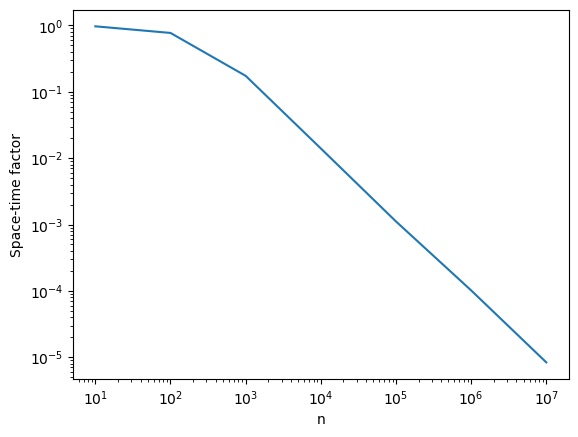

In [7]:
# plot assuming you can fit in n terms every transform
# actual performance will be scaled down by the average number of terms that can be fit in
# makes sense to use a normalised [avg number of terms] / n
plt.loglog(ns, st_factors)
plt.xlabel("n")
plt.ylabel("Space-time factor")